In [1]:
"""This class is used for quantitative evaluation of detected results"""

import numpy as np
import math
import matplotlib.pyplot as plt
from tifffile import imread
import json
import operator
from tqdm import tqdm

__docformat__ = 'reStructuredText'

class BlobMetrics(object):

    """
    BlobMetrics class can be instantiated with the following args

    - **parameters**, **types**, **return** and **return types**::
    :param ground_truth_coords: full path to the CSV file having annotations
    :param predicted_coords: full path to the CSV file having the predictions
    :param euclidean_distance_threshold: (optional) euclidean distance in voxels, within which a ground truth and prediction are considered as a hit
    :type ground_truth_coords: list [z,y,x]
    :type predicted_coords: list [z,y,x]
    :type euclidean_distance_threshold: integer
    """

    def __init__(
        self,
        ground_truth_coords,
        predicted_coords,
        euclidean_distance_threshold=0,
        ):
        self.ground_truth_coords = ground_truth_coords
        self.predicted_coords = predicted_coords
        self.edist = euclidean_distance_threshold

        [self.tp, self.tn, self.fp, self.fn] = self._get_submetrics()

    def _get_submetrics(self, edist=None):
        if edist == None:
            edist = self.edist

        tp = self._get_true_positives(edist)
        tn = 0.0

        fp = float(abs(len(self.predicted_coords) - tp))
        fn = float(abs(len(self.ground_truth_coords) - tp - fp))

        return [tp, tn, fp, fn]

    def _euclidean_distance(self, p1, p2):
        return np.linalg.norm(np.array(p1, dtype='float32') - np.array(p2, dtype='float32'))

    def _get_true_positives(self, edist=None):
        if edist == None:
            edist = self.edist

        point_map = {}

        for p in self.ground_truth_coords:
            point_map[repr(p)] = []

        for (i, p) in enumerate(self.predicted_coords):
            (nearest_point, dist) = \
                self._find_nearest_point(self.ground_truth_coords, p,
                    edist)
            if nearest_point is not None:
                d = {'point': p, 'edist': dist}
                point_map[repr(nearest_point)].append(d)

        predicted_points_with_match = set()
        for k in point_map:
            dist_info = point_map[k]
            dist_info = sorted(dist_info, key=lambda l: l['edist'])
            if len(dist_info) > 0:
                predicted_points_with_match.add(repr(dist_info[0]['point'
                        ]))

        return float(len(list(predicted_points_with_match)))

    def _find_nearest_point(
        self,
        points,
        point,
        edist=None,
        return_candidate_points=False,
        ):
        if edist == None:
            edist = self.edist

        min_dist = float('inf')
        nearest_point = None
        candidate_points = []

        for p in points:
            euc_dist = self._euclidean_distance(p, point)
            if euc_dist <= edist and euc_dist < min_dist:
                min_dist = euc_dist
                nearest_point = p
                candidate_points.append(p)

        if return_candidate_points:
            return [nearest_point, min_dist, candidate_points]

        return [nearest_point, min_dist]

    def accuracy(self):
        """True positives / Number of ground truth labels"""
        return round(self.tp / float(len(self.ground_truth_coords)) * 100, 3)

    def precision(self):
        """True positives / true positives + false positives"""
        return round(self.tp / (self.tp + self.fp), 3)

    def recall(self):
        """True positives / true positives + false negatives"""
        return round(self.tp / (self.tp + self.fn), 3)

    def mean_square_error(self, edist=None):
        """Sum of euclidean distances between predicted and ground truth labels"""
        if edist == None:
            edist = self.edist

        square_error_sum = 0.0
        n = 0

        for p in self.predicted_coords:
            (nearest_point, dist) = \
                self._find_nearest_point(self.ground_truth_coords, p,
                    edist)
            if nearest_point is not None:
                square_error_sum += self._euclidean_distance(p,
                        nearest_point) ** 2
                n += 1
        if n == 0:
            return 0
        return round(square_error_sum / n, 3)

    def f_measure(self):
        """(2 x precision x recall)/(precision + recall)"""
        p = self.precision()
        r = self.recall()

        return 2 * p * r / (p + r)

    def g_measure(self):
        """sqrt(precision x recall)"""
        p = self.precision()
        r = self.recall()

        return math.sqrt(p * r)

    def plot_predictions_with_ground_truth(self, fname=None):
        """Plots a visualization of predictions with ground truth labels"""
        x_gt = np.array([i[0] for i in self.ground_truth_coords])
        y_gt = np.array([i[1] for i in self.ground_truth_coords])
        z_gt = np.array([i[2] for i in self.ground_truth_coords])

        x_pr = np.array([i[0] for i in self.predicted_coords])
        y_pr = np.array([i[1] for i in self.predicted_coords])
        z_pr = np.array([i[2] for i in self.predicted_coords])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        gt = ax.scatter(
            x_gt,
            y_gt,
            z_gt,
            c='green',
            marker='o',
            alpha=0.5,
            )
        pr = ax.scatter(
            x_pr,
            y_pr,
            z_pr,
            c='red',
            s=50,
            marker='o',
            alpha=0.2,
            )

        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        ax.legend((gt, pr), ('Ground Truth', 'Predicted'),
                  scatterpoints=1, loc='lower left', fontsize=10)
        ax.set_title('Ground Truth vs Predicted', fontsize=12)

        fig.tight_layout()

        if fname:
            plt.savefig(fname)
        else:
            plt.show()

    def plot_accuracy_sensitivity(self):
        """Plots change of accuracy with euclidean_distance_threshold"""
        edist_range = list(set([abs(i) for i in range(int(self.edist) - 10,
                           int(self.edist) + 11)]))
        accuracies = []

        for dist in edist_range:
            [tp, _, _, _] = self._get_submetrics(dist)
            accuracies.append(tp / float(len(self.ground_truth_coords))
                              * 100)

        (fig, ax) = plt.subplots()
        ax.plot(edist_range, accuracies, marker='o')

        ax.set_xlabel('Euclidean distance threshold', fontsize=10)
        ax.set_ylabel('Accuracy (%)', fontsize=10)
        ax.set_title('Euclidean distance threshold vs Accuracy',
                     fontsize=12)

        plt.show()

    def plot_fmeasure_sensitivity(self):
        """Plots change of F-Measure with euclidean_distance_threshold"""
        edist_range = list(set([abs(i) for i in range(int(self.edist) - 10,
                           int(self.edist) + 11)]))
        fmeasures = []

        for dist in edist_range:
            [tp, tn, fp, fn] = self._get_submetrics(dist)

            p = tp / (tp + fp)
            r = tp / (tp + fn)

            fmeasures.append(2 * p * r / (p + r))

        (fig, ax) = plt.subplots()
        ax.plot(edist_range, fmeasures, marker='o')

        ax.set_xlabel('Euclidean distance threshold', fontsize=10)
        ax.set_ylabel('F-measure', fontsize=10)
        ax.set_title('Euclidean distance threshold vs F-measure',
                     fontsize=12)

        plt.show()

    def plot_mean_square_error_sensitivity(self):
        """Plots change of mean square error with euclidean_distance_threshold"""
        edist_range = list(set([abs(i) for i in range(self.edist - 10,
                           self.edist + 11)]))
        mse = []

        for dist in edist_range:
            mse.append(self.mean_square_error(dist))

        (fig, ax) = plt.subplots()
        ax.plot(edist_range, mse, marker='o')

        ax.set_xlabel('Euclidean distance threshold', fontsize=10)
        ax.set_ylabel('Mean Square Error', fontsize=10)
        ax.set_title('Euclidean distance threshold vs Mean Square Error'
                     , fontsize=12)

        plt.show()

    def plot_predictions_per_ground_truth(self, fname=None):
        """Plots a bar graph of number of predictions for each ground truth"""
        counts = {}
        for p in self.ground_truth_coords:
            (_, _, candidate_points) = \
                self._find_nearest_point(self.predicted_coords, p,
                    self.edist, True)
            c = len(candidate_points)
            if c not in counts:
                counts[c] = 1
            else:
                counts[c] += 1

        (fig, ax) = plt.subplots()

        total_count = sum(counts.values())
        for c in counts.keys():
            counts[c] = float(counts[c]) #/float(total_count)

        ax.bar(list(counts.keys()), list(counts.values()))
        ax.set_xlabel('# predictions', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        plt.xticks(list(counts.keys()), list(counts.keys()))
        ax.set_title('Number of predictions per ground truth label',
                     fontsize=12)
        if fname:
            plt.savefig(fname)
        else:
            plt.show()

    def plot_ground_truths_per_prediction(self, fname=None):
        """Plots a bar graph of number of ground truth labels for each prediction"""
        counts = {}
        for p in self.predicted_coords:
            (_, _, candidate_points) = \
                self._find_nearest_point(self.ground_truth_coords, p,
                    self.edist, True)
            c = len(candidate_points)
            if c not in counts:
                counts[c] = 1
            else:
                counts[c] += 1

        (fig, ax) = plt.subplots()

        total_count = sum(counts.values())
        for c in counts.keys():
            counts[c] = float(counts[c]) #/float(total_count)

        ax.bar(list(counts.keys()), list(counts.values()))
        ax.set_xlabel('# ground truths', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        plt.xticks(list(counts.keys()), list(counts.keys()))
        ax.set_title('Number of ground truth labels per prediction',
                     fontsize=12)
        if fname:
            plt.savefig(fname)
        else:
            plt.show()

    def _get_child_nodes_from_ontology(self, node, id2name):
        id2name[node['id']] = node['name']
        # base case
        if node['children'] == []:
            return id2name
        # other case
        for i in range(len(node['children'])):
            id2name = self._get_child_nodes_from_ontology(node['children'][i], id2name)
        return id2name

    def get_region_based_count(self, ontology_file, registered_brain_tif):
        """Given a region ontology file and a registered annotated brain, this method returns the number of predicted cells in each region"""
        ontology_json = json.load(open(ontology_file, 'r'))
        id2name = self._get_child_nodes_from_ontology(ontology_json, {})

        id2name[32767] = 'background'

        background_region_number = 0
        registered_brain = imread(registered_brain_tif).astype(np.uint64)
        region_numbers = list(np.unique(registered_brain, return_counts=True)[0])
        region2voxel = {}

        reg_pbar = tqdm(region_numbers)

        for region in reg_pbar:
            reg_pbar.set_description('Processing region {}'.format(region))

            voxels = np.where(registered_brain == region)
            region2voxel[region] = map(list, zip(*voxels))

        coord_pbar = tqdm(self.predicted_coords)
        region_count = {}

        for p in coord_pbar:
            coord_pbar.set_description('Processing centroid {}'.format(p))
            rp = registered_brain[int(p[0]), int(p[1]), int(p[2])]

            if id2name[rp] in region_count:
                region_count[id2name[rp]] += 1
            else:
                region_count[id2name[rp]] = 1

        return [id2name, region_count]

    def plot_region_based_count(self, count_statistics=None, fig_path=None):
        """Plots a number of cells in each region"""
        count_statistics = sorted(count_statistics.items(), key=operator.itemgetter(1))
        count_statistics.reverse()

        bar_x = np.arange(5)
        bar_y = [(float(c[1])/len(self.predicted_coords)) for c in count_statistics[:5]]
        labels = [c[0] for c in count_statistics[:5]]
        colors = ['red', 'green', 'blue', 'cyan', 'magenta']

        (fig, ax) = plt.subplots()

        for i,y in enumerate(bar_y):
            ax.bar(i, y, label=labels[i], color=colors[i], width=0.8, align='center', alpha=0.6)

        ax.set_xlabel('Region', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        #plt.xticks(list(counts.keys()), list(counts.keys()))
        ax.get_xaxis().set_ticks([])
        ax.set_title('Region wise cell count',
                     fontsize=16)
        ax.legend()

        if fig_path:
            plt.savefig(fig_path)
        else:
            plt.show()

    def plot_intensity_mapping(self, region_intensities, reg_atlas_tif, id2name, fig_path=None):
        """Plots intensity sum of each region"""
        total_intensity = np.sum(list(region_intensities.values()))
        for k in region_intensities.keys():
            region_intensities[k] = float(region_intensities[k]) / float(total_intensity)

        reg_atlas = imread(reg_atlas_tif)
        region_numbers = np.unique([reg_atlas[int(p[0]), int(p[1]), int(p[2])] for p in self.predicted_coords])
        intensity_stats = {reg: region_intensities[str(reg)] for reg in region_numbers}

        intensity_stats = sorted(intensity_stats.items(), key=operator.itemgetter(1))
        intensity_stats.reverse()


        bar_x = np.arange(5)
        bar_y = [v[1] for v in intensity_stats[:5]]
        labels = [id2name[v[0]] for v in intensity_stats[:5]]
        colors = ['red', 'green', 'blue', 'cyan', 'magenta']

        (fig, ax) = plt.subplots()

        for i,y in enumerate(bar_y):
            ax.bar(i, y, label=labels[i], color=colors[i], width=0.8, align='center', alpha=0.6)

        ax.set_xlabel('Region', fontsize=12)
        ax.set_ylabel('Intensity', fontsize=12)

        ax.get_xaxis().set_ticks([])
        ax.set_title('Region wise intensity sum',
                     fontsize=16)
        ax.legend()

        if fig_path:
            plt.savefig(fig_path)
        else:
            plt.show()


/Users/vikramchandrashekhar/.virtualenvs/bloby/lib/python3.6/site-packages/tifffile/tifffile.py:306: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


In [2]:
"""Utility functions"""

import csv
import tifffile as tiff
import numpy as np
import os

def get_list_from_csv(csv_file_path, parse_float=True, skip_header=False):
    """Given a CSV file, converts it to list"""
    def _parse_float_array(arr):
        return [float(item) for item in arr]

    with open(csv_file_path, 'r') as f:
        reader = csv.reader(f)
        csv_list = list(reader)

    parsed_list = csv_list

    if parse_float:
        parsed_list = [_parse_float_array(item) for item in csv_list]

    return parsed_list[1:] if skip_header else parsed_list

def plot_csv_on_rgb_tif(centroids, reference_img_path, tif_output_path, color=[10000, 0, 0]):
    """Given a CSV file, plots the co-ordinates in the CSV on a RGB TIF stack"""
    def _parse_int_array(arr):
        return [int(item) for item in arr]

    def _draw_square(image, coord, size=2):
        coord = _parse_int_array(coord)
        shape_z, shape_y, shape_x, _ = image.shape
        z_range = range(max(0, coord[0]-size), min(shape_z, coord[0]+size))
        y_range = range(max(0, coord[1]-size), min(shape_y, coord[1]+size))
        x_range = range(max(0, coord[2]-size), min(shape_x, coord[2]+size))

        for z in z_range:
            for y in y_range:
                for x in x_range:
                    image[z, y, x, :] = color

        return image

    img = tiff.imread(reference_img_path)


    if img.ndim == 3:
        shape_z, shape_y, shape_x = img.shape
        new_img = np.zeros((shape_z, shape_y, shape_x, 3))
        new_img[:, :, :, 0] = img
        new_img[:, :, :, 1] = img
        new_img[:, :, :, 2] = img
    elif img.ndim == 4:
        shape_z, shape_y, shape_x, _ = img.shape
        new_img = img

    for i, c in enumerate(centroids):
        new_img = _draw_square(new_img, c)

    tiff.imsave(tif_output_path, new_img.astype(np.uint16))

def plot_csv_on_tif(centroids, reference_img_path, tif_output_path):
    """Given a CSV file, plots the co-ordinates in the CSV on a TIF stack"""
    def _parse_int_array(arr):
        return [int(item) for item in arr]

    def _draw_square(image, coord, size=2):
        coord = _parse_int_array(coord)
        shape_z, shape_y, shape_x = image.shape
        z_range = range(max(0, coord[0]-size), min(shape_z, coord[0]+size))
        y_range = range(max(0, coord[1]-size), min(shape_y, coord[1]+size))
        x_range = range(max(0, coord[2]-size), min(shape_x, coord[2]+size))

        for z in z_range:
            for y in y_range:
                for x in x_range:
                    image[z, y, x] = 255

        return image

    ref_image = tiff.imread(reference_img_path)
    shape_z, shape_y, shape_x = ref_image.shape

    annotated_image = np.zeros((shape_z, shape_y, shape_x))

    for i, c in enumerate(centroids):
        annotated_image = _draw_square(annotated_image, c)

    tiff.imsave(tif_output_path, annotated_image.astype(np.uint8))

def write_list_to_csv(arr, csv_output_path):
    """Given a list, writes it to a CSV file"""
    with open(csv_output_path, 'w') as csv_file:
        for item in arr:
            csv_file.write(','.join([str(x) for x in item]) + '\n')

def create_intern_config():
    """Creates intern.cfg file from BOSS_TOKEN environment variable"""
    INTERN_CFG = 'intern.cfg'
    if os.path.exists(INTERN_CFG):
        os.remove(INTERN_CFG)

    boss_token = os.environ['BOSS_TOKEN']
    with open('intern_cfg_tmpl', 'r') as cfg_file:
        cfg_str = cfg_file.read()

    with open('intern.cfg', 'w') as cfg_file:
        cfg_file.write(cfg_str.format(boss_token))

In [3]:
import tifffile as tf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from mpl_toolkits.mplot3d import Axes3D

In [5]:
import skimage

In [6]:
from skimage.filters import threshold_otsu, rank
import skimage.feature as feature
from skimage.morphology import selem
import scipy.ndimage.filters as filters

In [7]:
import PIL.ImageDraw as ID
import PIL

In [8]:
dataset = 'cell_detection_0'

In [9]:
img = tf.imread('cobalt/src/sample_data/cell_detection/{}.tiff'.format(dataset))

In [10]:
img.shape

(100, 500, 500)

In [11]:
truth = get_list_from_csv('cobalt/src/annotation_csv/cell_detection/{}_final.csv'.format(dataset))

In [12]:
len(truth)

45

In [24]:
img_r = skimage.transform.rescale(img, (5.0,0.5,0.5), anti_aliasing=True, multichannel=False)

/Users/vikramchandrashekhar/scikit-image/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [25]:
img_r.shape

(500, 250, 250)

/Users/vikramchandrashekhar/.virtualenvs/bloby/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


(<matplotlib.figure.Figure at 0x1133fa198>,
 <matplotlib.image.AxesImage at 0x113be8d68>)

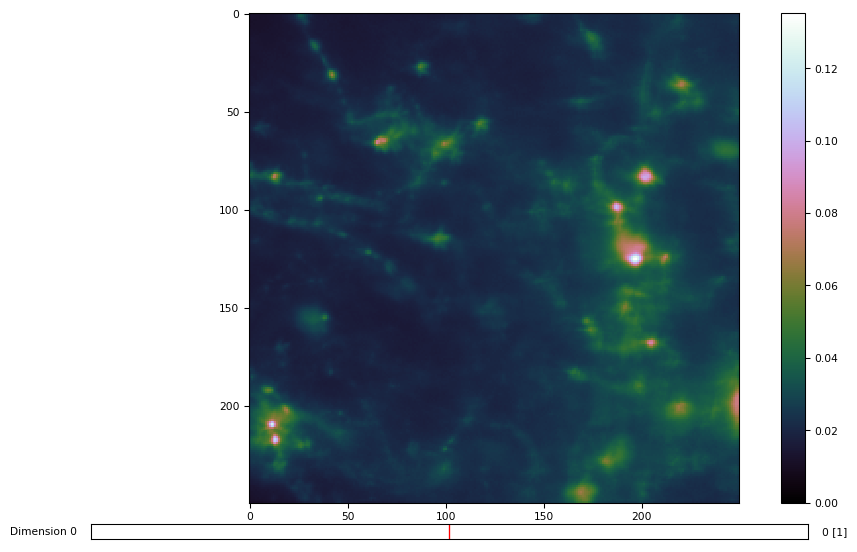

In [28]:
tf.imshow(img_r[400,:,:])

In [29]:
%%time
blobs = feature.blob_log(img_r, min_sigma=0.5, max_sigma=5,
                         threshold=0.1, num_sigma=10, overlap=1.0)

CPU times: user 55.4 s, sys: 7.55 s, total: 1min 2s
Wall time: 1min 5s


In [30]:
len(blobs)

118

In [22]:
blobs

array([[ 95. ,  13. ,  35. ,   0.5],
       [ 88. ,  47. ,  19. ,   0.5],
       [ 86. ,  46. ,  20. ,   0.5],
       [ 75. ,  48. ,  34. ,   0.5],
       [ 74. ,  44. ,  37. ,   0.5],
       [ 73. ,  12. ,  16. ,   0.5],
       [ 71. ,  40. ,  43. ,   0.5],
       [ 70. ,  44. ,   1. ,   0.5],
       [ 66. ,  44. ,   1. ,   0.5],
       [ 62. ,  29. ,  41. ,   0.5],
       [ 59. ,  49. ,  21. ,   0.5],
       [ 59. ,  45. ,  34. ,   0.5],
       [ 58. ,  31. ,  36. ,   0.5],
       [ 53. ,  31. ,  31. ,   0.5],
       [ 49. ,  34. ,  39. ,   0.5],
       [ 49. ,  32. ,  36. ,   0.5],
       [ 45. ,  32. ,  35. ,   0.5],
       [ 40. ,  35. ,  37. ,   0.5],
       [ 37. ,  32. ,  19. ,   0.5],
       [ 35. ,  43. ,  43. ,   0.5],
       [ 34. ,  48. ,  46. ,   0.5],
       [ 34. ,  40. ,  37. ,   0.5],
       [ 32. ,  42. ,  13. ,   0.5],
       [ 32. ,  11. ,  43. ,   0.5],
       [ 31. ,  49. ,  35. ,   0.5],
       [ 30. ,  28. ,  48. ,   0.5],
       [ 29. ,  33. ,  31. ,   0.5],
 

In [28]:
write_list_to_csv(blobs[:,:3],  'test_dog_cd5.csv')

In [41]:
plot_csv_on_rgb_tif(blobs[:,:3], 'cobalt/src/sample_data/cell_detection/{}.tiff'.format(dataset), 
                    'test_dog_cd5.tiff', color=[50000,0,0])

In [42]:
plot_csv_on_rgb_tif(truth, 'test_dog_cd5.tiff', 
                    'test_dog_cd5_and_ground_truth.tiff', color=[0,50000,0])

In [31]:
bd = BlobMetrics(truth, blobs[:,:3], euclidean_distance_threshold=10.0)

In [32]:
bd.accuracy()

57.778

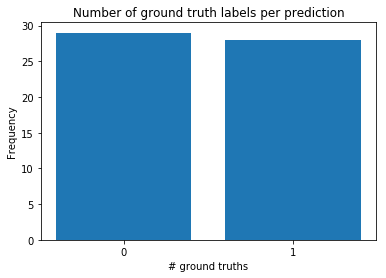

In [33]:
bd.plot_ground_truths_per_prediction()

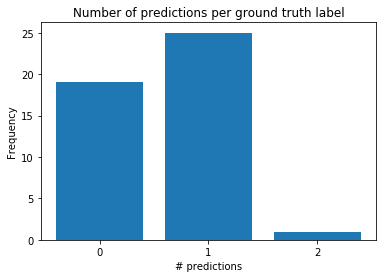

In [34]:
bd.plot_predictions_per_ground_truth()

In [35]:
bd.precision()

0.456

In [36]:
bd.recall()

0.684

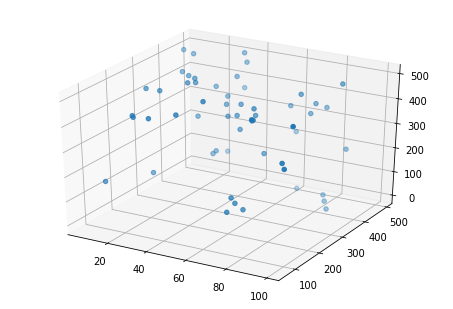

In [37]:
Axes3D(plt.figure()).scatter(blobs[:,0], blobs[:,1], blobs[:,2])

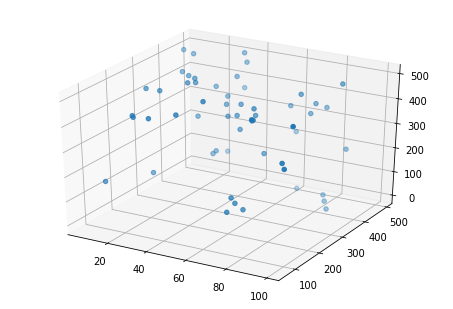

In [38]:
Axes3D(plt.figure()).scatter(blobs[:,0], blobs[:,1], blobs[:,2])

In [39]:
tf.imshow(out1[30,:,:], cmap='gray')
plt.show()

NameError: name 'out1' is not defined

/Users/vikramchandrashekhar/.virtualenvs/bloby/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


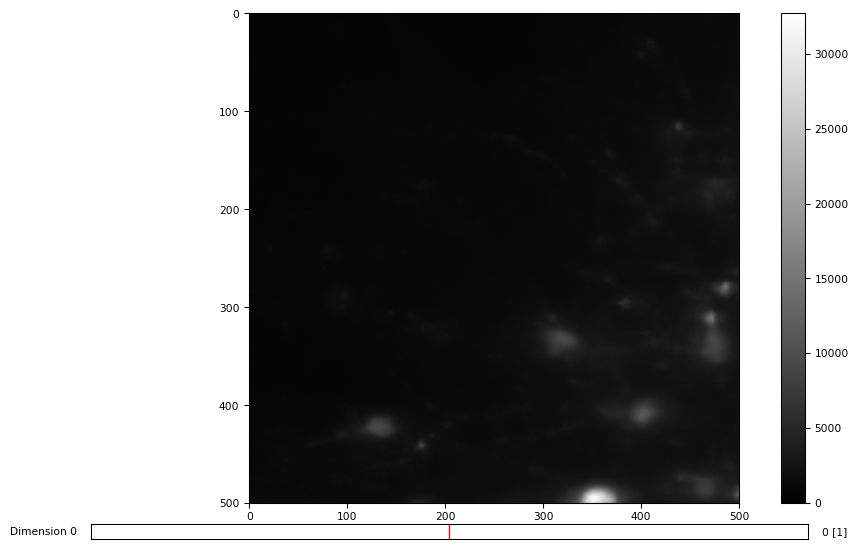

In [40]:
tf.imshow(img[30,:,:], cmap='gray')
plt.show()

In [7]:
slice_roi = img[20,:,:]

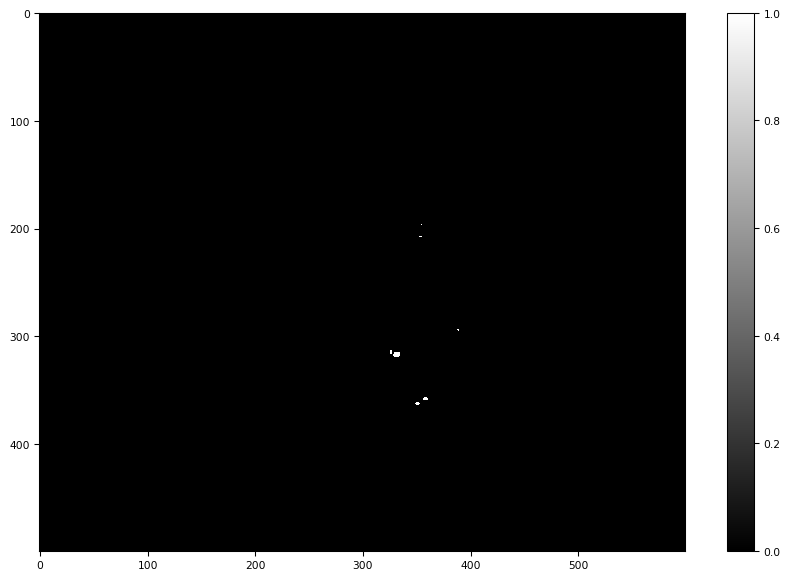

In [8]:
tf.imshow(slice_roi>=60000, cmap='gray')
plt.show()

(<matplotlib.figure.Figure at 0x1172b2668>,
 <matplotlib.image.AxesImage at 0x118155400>)

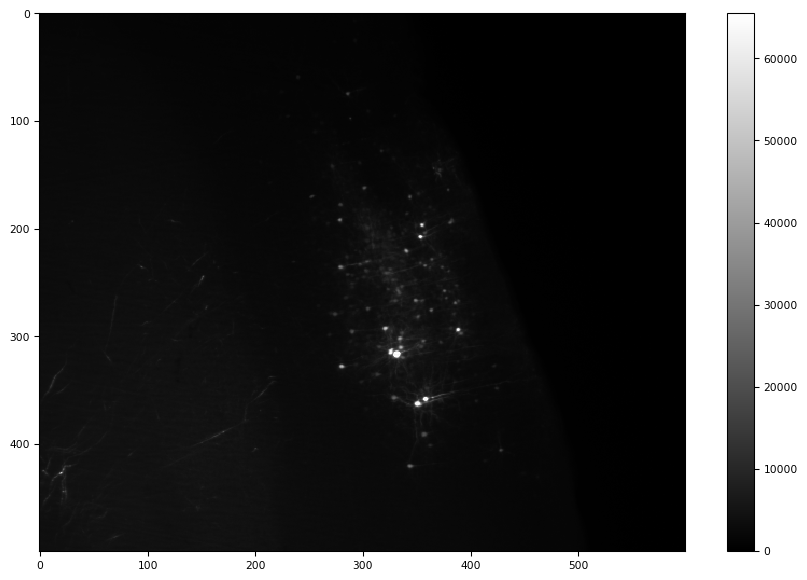

In [9]:
tf.imshow(slice_roi, cmap='gray')